# Increasing Nodes Results

These results plot our simulation metrics against increasing system sizes. 

In [1]:
%load_ext memory_profiler
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import graph_tool.all as gt
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.colors import ColorMap
from cloudscope.results import Results
from cloudscope.results.graph import extract_graph
from cloudscope.results.analysis import create_per_replica_dataframe as create_replica_dataframe
from cloudscope.results.analysis import create_per_experiment_dataframe as create_dataframe

In [19]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('Set1', n_colors=9)

In [3]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures", "results")
FIGURES  = os.path.join("..", "fixtures", "figures", "scaling-systems")
RESULTS  = os.path.join(FIXTURES, "scaling-systems.json")

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        for line in f:
            yield Results.load(line)

In [15]:
%%memit 
df = create_dataframe(get_results_data())

peak memory: 4374.85 MiB, increment: 3731.08 MiB


In [16]:
# Uncomment below if you need to see the columns
# print("\n".join(df.columns))

# Add the ename to identify the experiment
df['ename'] = df['users'].apply(str) + " " + df['type'] + " nodes"
df['type']  = df['type'].apply(lambda s: s.title())

In [17]:
df

T parameter model  anti-entropy delay (ms)  committed writes  \
0            bailis                      600           23036.0   
1            bailis                      600            4900.0   
2            bailis                      600           43324.0   
3            bailis                     2500               0.0   
4            bailis                      600           61714.0   
5            bailis                      600           78631.0   
6            bailis                     2500               0.0   
7            bailis                     2500               0.0   
8            bailis                     2500               0.0   
9            bailis                     2500               0.0   

   completed reads  completed writes  conflict probability  dropped messages  \
0            34492             23100                   0.0                 0   
1             6844              4935                   0.0                 0   
2            68864             43413                   0.0                 0   
3             6898              5020                   0.0                 0   
4           103645             61832                   0.0                 0   
5           137593             78753                   0.0                 0   
6            34730             25197                   0.0                 0   
7            69423             50464                   0.0                 0   
8           104174             75609                   0.0                 0   
9           139034            100787                   0.0                 0   

   dropped writes  eid election timeout (ms, ms)         ...          \
0          2097.0  e00            [10000, 20000]         ...           
1            85.0  e01            [10000, 20000]         ...           
2          7051.0  e02            [10000, 20000]         ...           
3             0.0  e03                [150, 300]         ...           
4         13777.0  e04            [10000, 20000]         ...           
5         22034.0  e05            [10000, 20000]         ...           
6             0.0  e06                [150, 300]         ...           
7             0.0  e07                [150, 300]         ...           
8             0.0  e08                [150, 300]         ...           
9             0.0  e09                [150, 300]         ...           

   standard deviation of latency (ms)  tick metric (T)      type  \
0                                  56            10000      Raft   
1                                  56            10000      Raft   
2                                  56            10000      Raft   
3                                  56            10000  Eventual   
4                                  56            10000      Raft   
5                                  56            10000      Raft   
6                                  56            10000  Eventual   
7                                  56            10000  Eventual   
8                                  56            10000  Eventual   
9                                  56            10000  Eventual   

  unforked writes  users  visibility  visible writes  writes  \
0          1970.0     25      554400           23036   25197   
1            72.0      5       19740            4900    5020   
2          6660.0     50     2127237           43324   50464   
3             0.0      5       16194            3061    5020   
4         13380.0     75     4575568           61714   75609   
5         21059.0    100     7796547           78631  100787   
6             0.0     25      385794            5886   25197   
7             0.0     50     1418528            6514   50464   
8             0.0     75     2901987            5775   75609   
9             0.0    100     4715849            4834  100787   

   inconsistent writes               ename  
0                  0.0       25 raft nodes  
1                  0.0        5 raft nodes  
2           

peak memory: 661.49 MiB, increment: 5.47 MiB


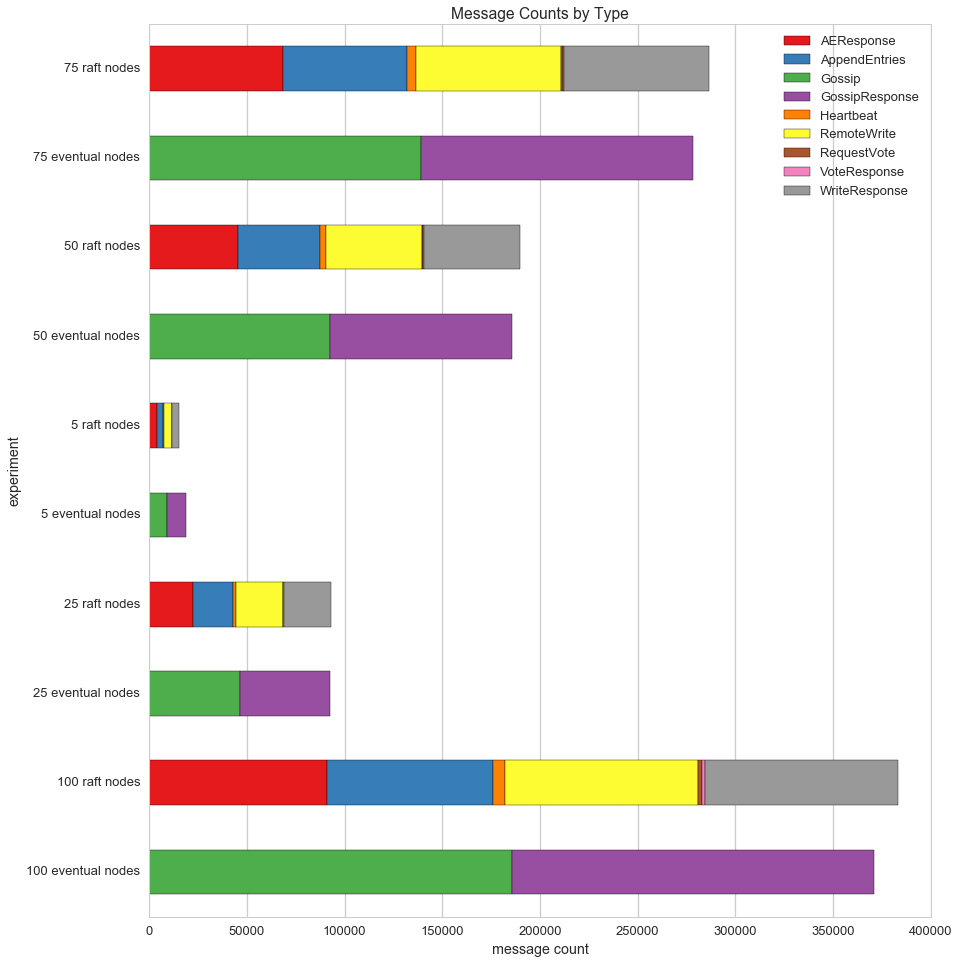

In [20]:
%%memit

def get_message_rows(df):
    for row in df[['message types', 'ename']].itertuples(): 
        item = row[1]
        item['experiment'] = row[2]
        yield item

# Create the data frame 
msgs = pd.DataFrame(sorted(get_message_rows(df), key=lambda item: item['experiment']))

# Create the figure 
fig = plt.figure(figsize=(14,16))
ax  = fig.add_subplot(111)
mpl.rcParams.update({'font.size': 22})

# Plot the bar chart 
g = msgs.plot(
    x='experiment', kind='barh', stacked=True, ax=ax, 
    title="Message Counts by Type", color=sns.color_palette()
)

# Modify the figure 
ax.set_xlabel("message count")
ax.yaxis.grid(False)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'message_counts.png'))

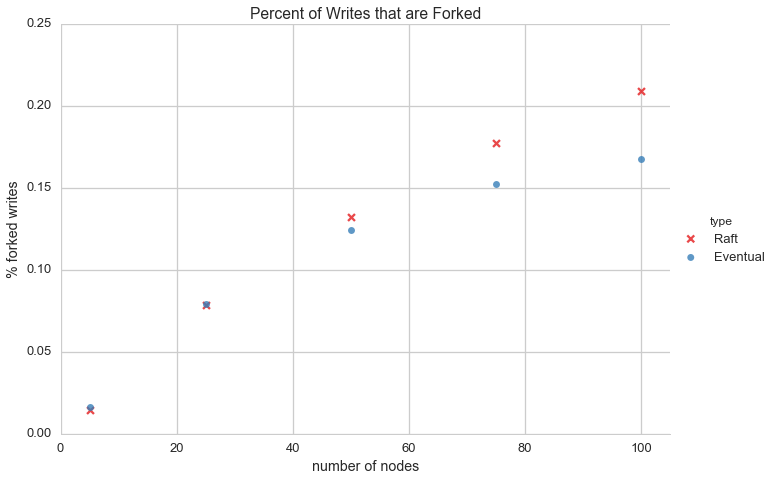

In [21]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
df['% forked writes'] = df['forked writes'] / df['writes']

g = sns.lmplot(
    x="users", y="% forked writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Percent of Writes that are Forked"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'forked_writes.png'))

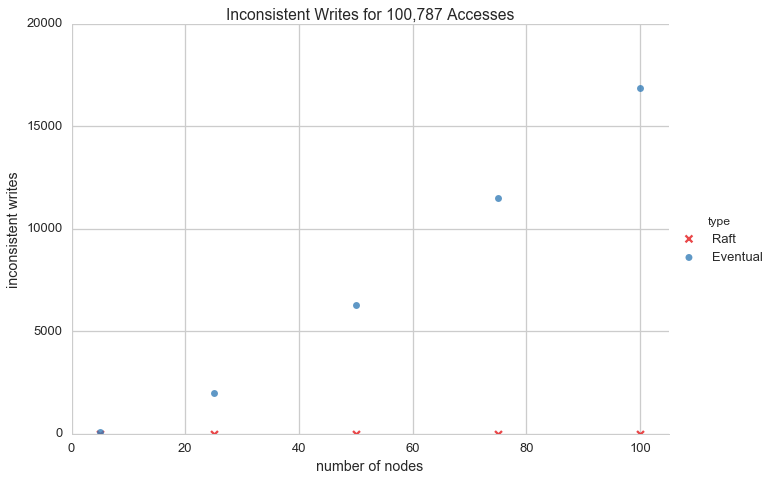

In [22]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
g = sns.lmplot(
    x="users", y="inconsistent writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Inconsistent Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'inconsistent_writes.png'))

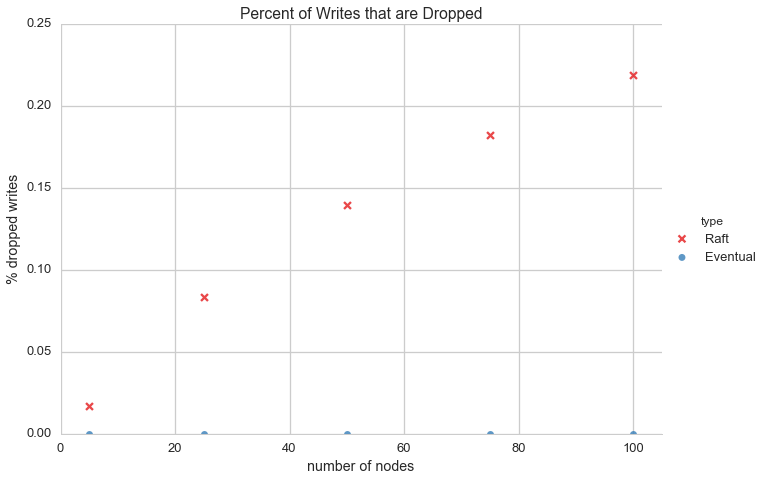

In [23]:
# Dropped Writes
df['% dropped writes'] = df['dropped writes'] / df['writes']

g = sns.lmplot(
    x="users", y="% dropped writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Percent of Writes that are Dropped"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'dropped_writes.png'))

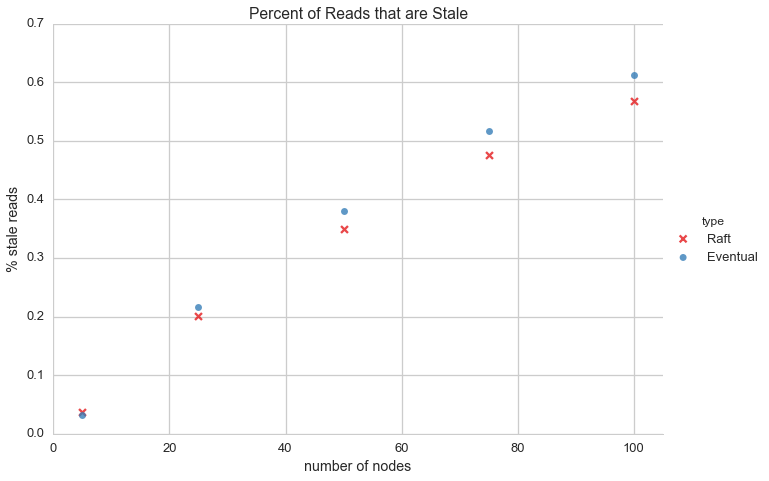

In [24]:
# Stale Reads
df['% stale reads'] = df['stale reads'] / df['reads']

g = sns.lmplot(
    x="users", y="% stale reads", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Percent of Reads that are Stale"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'stale_reads.png'))

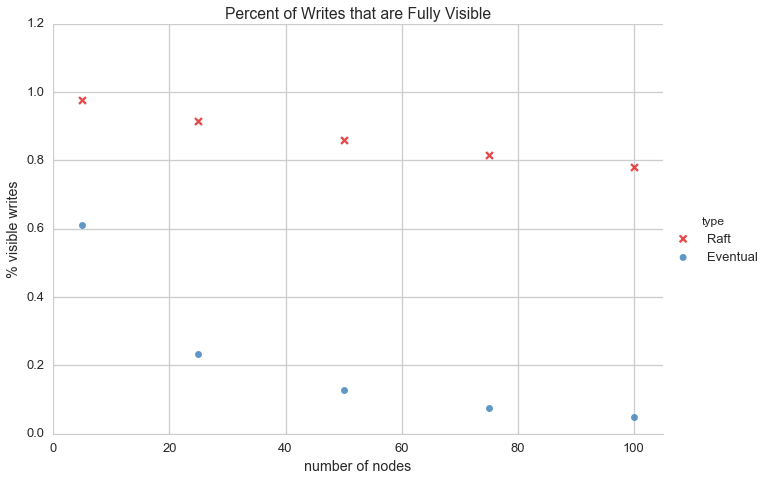

In [25]:
# Visible Writes
df['% visible writes'] = df['visible writes'] / df['writes']

g = sns.lmplot(
    x="users", y="% visible writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Percent of Writes that are Fully Visible"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visible_writes.png'))

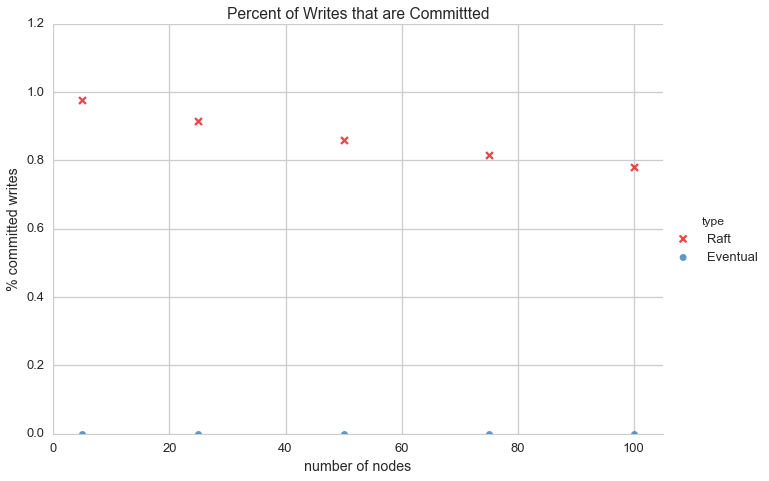

In [26]:
# Comitted Writes
df['% committed writes'] = df['committed writes'] / df['writes']

g = sns.lmplot(
    x="users", y="% committed writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Percent of Writes that are Committted"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'committed_writes.png'))

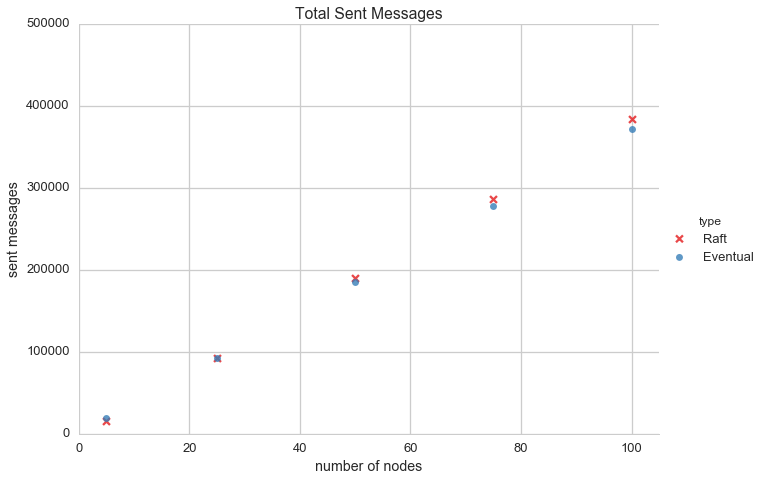

In [27]:
# Number of Messages 
g = sns.lmplot(
    x="users", y="sent messages", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Total Sent Messages"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'messages_sent.png'))

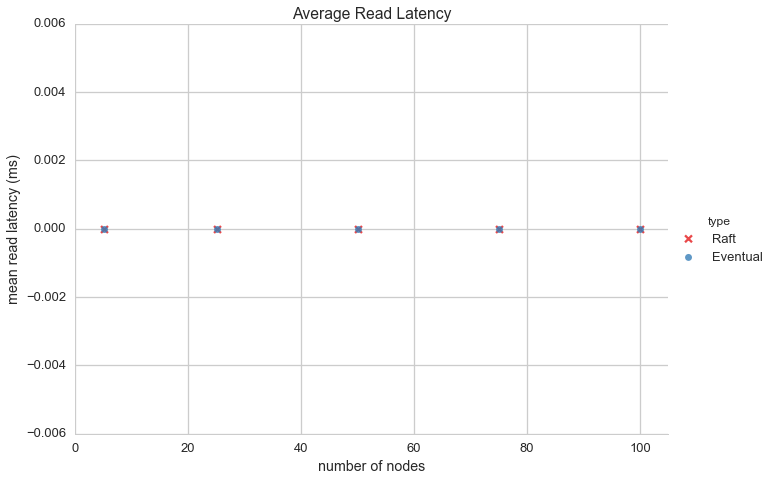

In [28]:
# Read latency (ms delay before read)
g = sns.lmplot(
    x="users", y="mean read latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Average Read Latency"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'read_latency.png'))

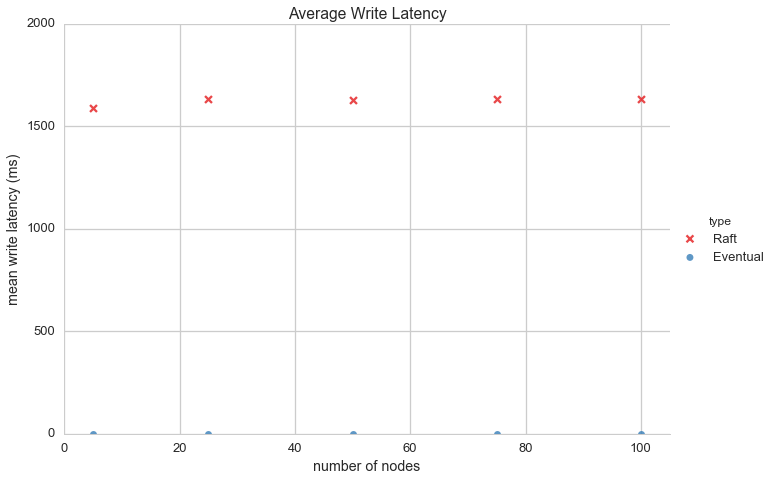

In [29]:
# Write Latency (ms delay before write)
g = sns.lmplot(
    x="users", y="mean write latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Average Write Latency"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'write_latency.png'))

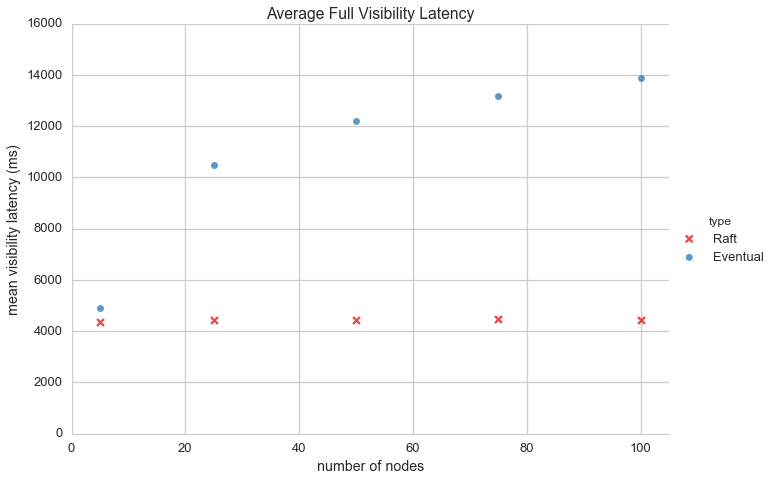

In [30]:
# Replication Latency (Visibility Latency)
g = sns.lmplot(
    x="users", y="mean visibility latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Average Full Visibility Latency"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visibility_latency.png'))

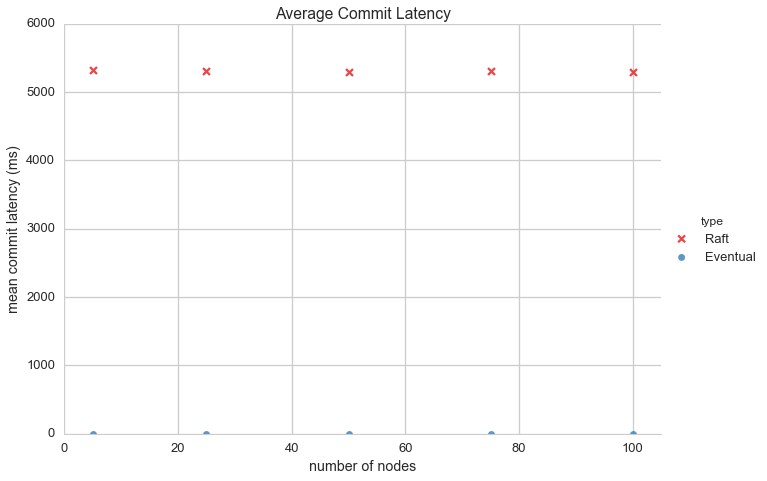

In [31]:
# Commit Latency
g = sns.lmplot(
    x="users", y="mean commit latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Average Commit Latency"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'commit_latency.png'))

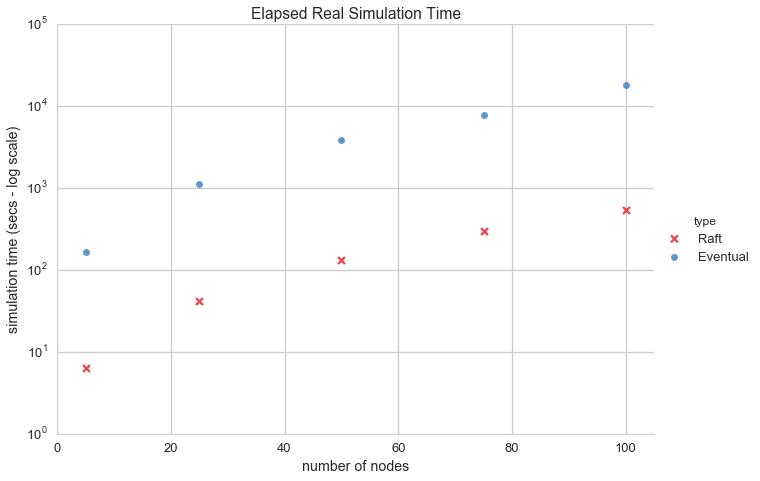

In [32]:
# Simulation Time
g = sns.lmplot(
    x="users", y="simulation time (secs)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Elapsed Real Simulation Time"
g.ax.set_title(title_fmt)
g.set(yscale="log")
g.set(ylabel="simulation time (secs - log scale)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'simulation_time.png'))

In [33]:
def find_results(etype='raft', users=None):
    for result in get_results_data():
        if result.settings['type'] == etype: 
            if (users and users == result.settings['users']) or users is None:
                name = "{}-{}nodes.png".format(etype, users)
                return result, name    
    return None, None 

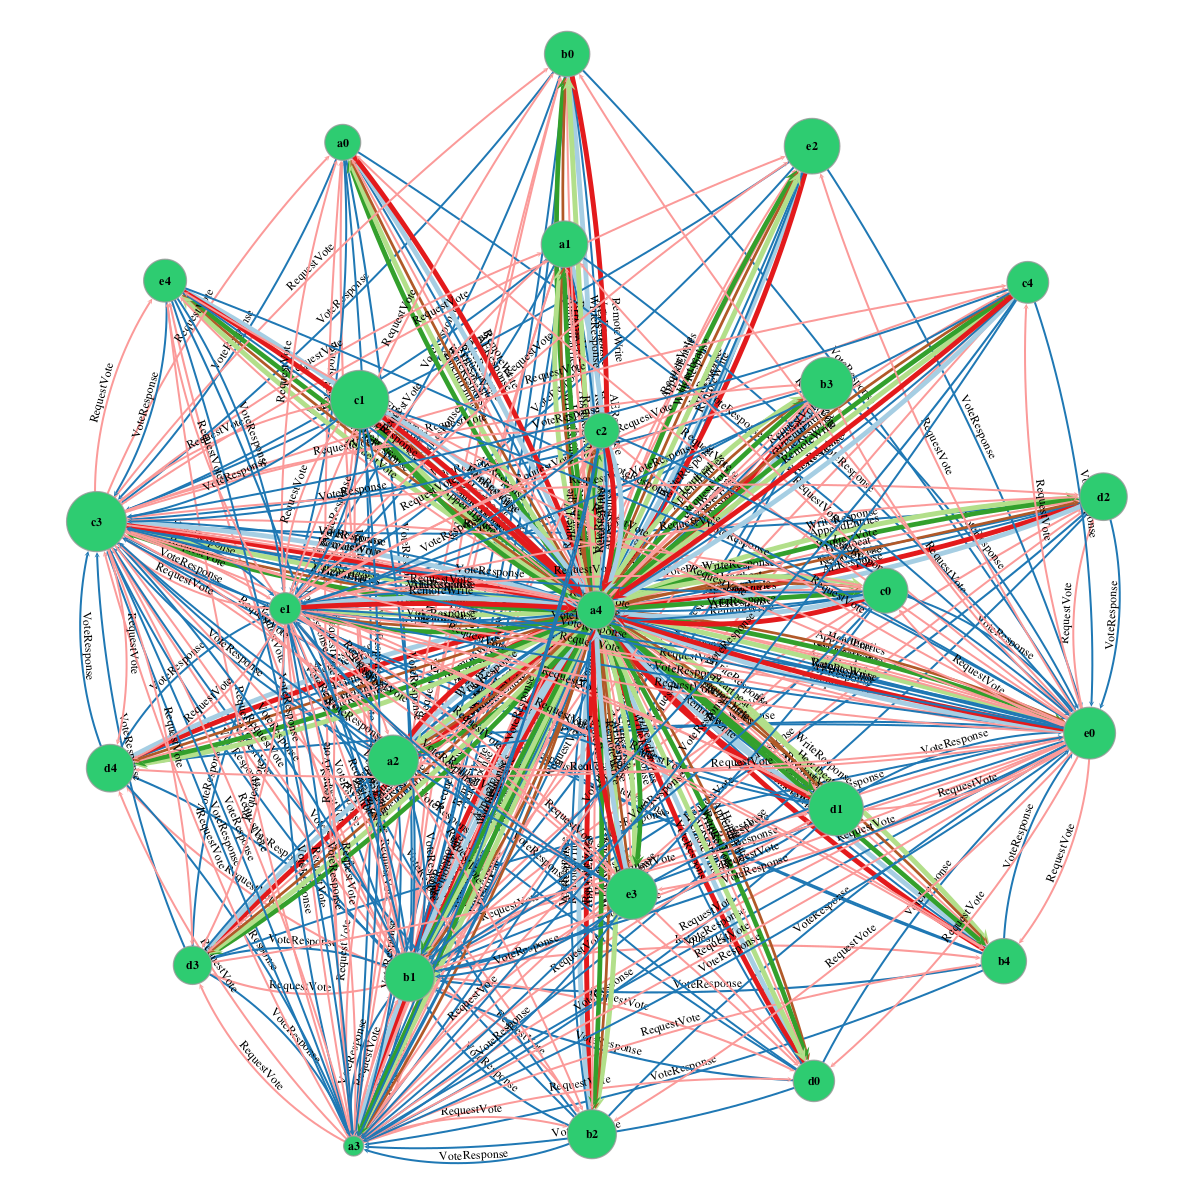

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1225afe50, at 0x12d8e6390>

In [5]:
# Draw the messages graph 

# Find the desired results 
result, name = find_results('raft', 25)
if result is None: raise ValueError("Could not find results!")

# Extract the Graph Tool graph     
G = extract_graph(result, by_message_type=True)

# Draw the graph 
vlabel  = G.vp['id']
vsize   = G.vp['writes']
vsize   = gt.prop_to_size(vsize, ma=60, mi=20)

# Set the vertex color 
vcolor  = G.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
vcmap('raft')
vcmap('eventual')
for vertex in G.vertices():
    vcolor[vertex] = vcmap(G.vp['consistency'][vertex])

# Set the edge color 
ecolor  = G.new_edge_property('string')
ecmap   = ColorMap('paired', shuffle=False)
for edge in G.edges():
    ecolor[edge] = ecmap(G.ep['label'][edge])

elabel  = G.ep['label']
esize   = G.ep['norm']
esize   = gt.prop_to_size(esize, mi=2, ma=5)

# Create the layout with the edge weights. 
# pos = gt.arf_layout(G, weight=G.ep['weight'])
pos = gt.sfdp_layout(G, eweight=G.ep['weight'], vweight=vsize)
# pos = gt.fruchterman_reingold_layout(G, weight=G.ep['weight'])

gt.graph_draw(
    G, pos=pos, output_size=(1200,1200), output=os.path.join(FIGURES, name),
    vertex_text=vlabel, vertex_size=vsize, vertex_font_weight=1, 
    vertex_pen_width=1.3, vertex_fill_color=vcolor,
    edge_pen_width=esize, edge_color=ecolor, edge_text=elabel
)

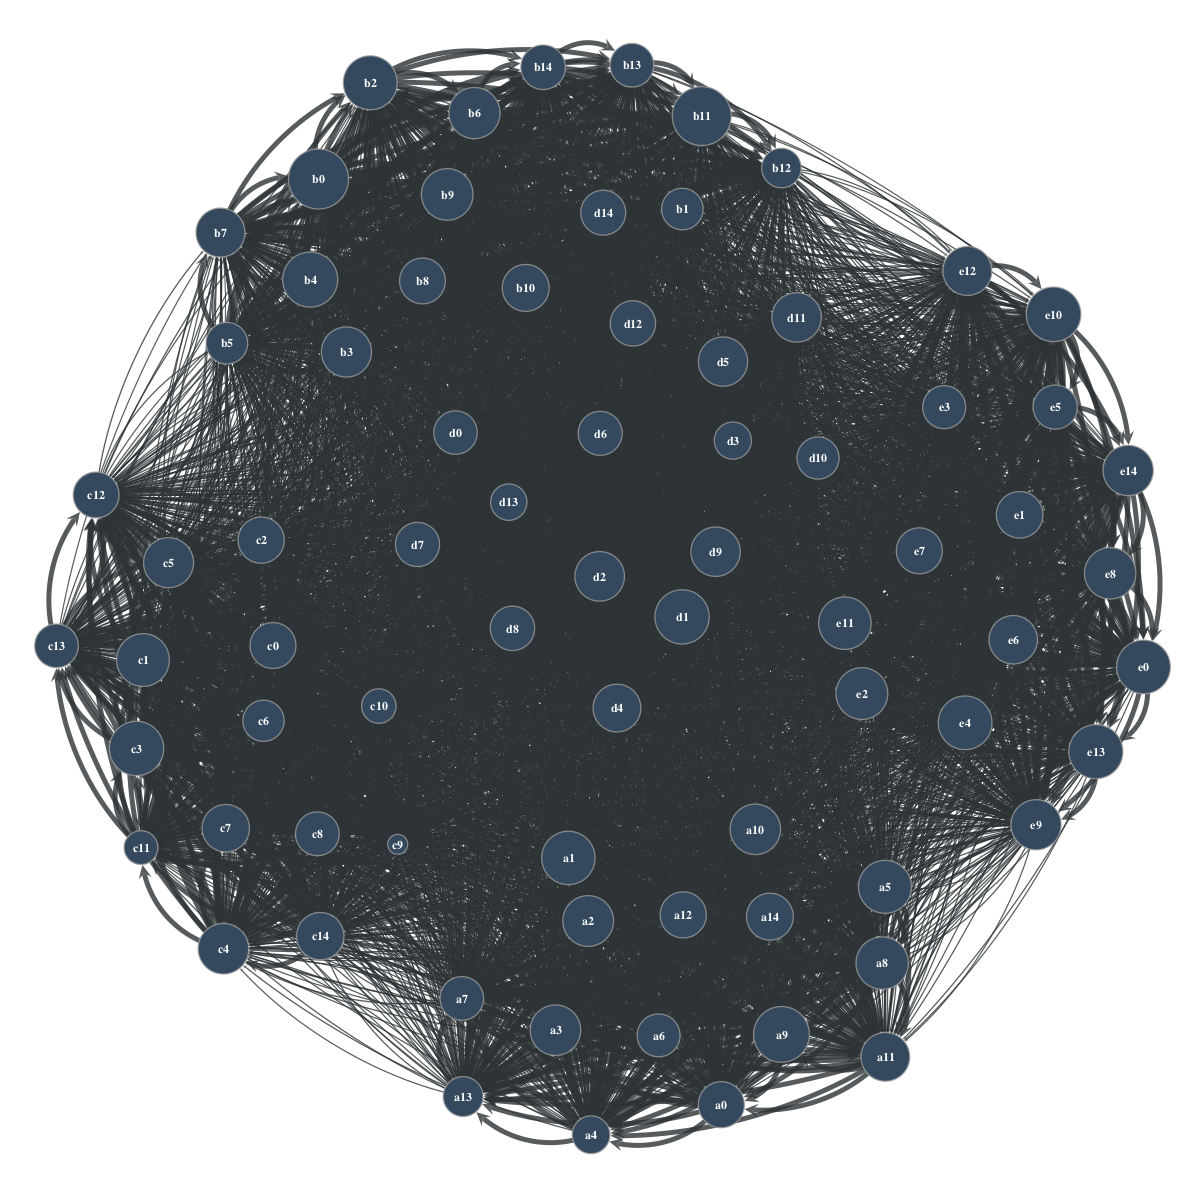

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1367782d0, at 0x1fb39f2d0>

In [35]:
# Draw the message latency graph 

# Find the desired results 
result, name = find_results('eventual', 75)
if result is None: raise ValueError("Could not find results!")

# Extract the Graph Tool graph     
G = extract_graph(result, by_message_type=False)

# Draw the graph 
vlabel  = G.vp['id']
vsize   = G.vp['sent']
vsize   = gt.prop_to_size(vsize, ma=60, mi=20)

# Set the vertex color 
vcolor  = G.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
vcmap('raft')
vcmap('eventual')

for vertex in G.vertices():
    vcolor[vertex] = vcmap(G.vp['consistency'][vertex])

# Make the edge weights the inverse of the latency mean (lower latency is higher weight)
esize = G.new_edge_property('float')
for edge in G.edges():
    esize[edge] = 1.0 / G.ep['mean'][edge]

esize   = gt.prop_to_size(esize, mi=1, ma=5)

# Create the layout with the edge weights. 
# pos = gt.arf_layout(G, weight=esize)
# pos = gt.sfdp_layout(G, eweight=esize, vweight=vsize)
pos = gt.fruchterman_reingold_layout(G, weight=esize)

gt.graph_draw(
    G, pos=pos, output_size=(1200,1200), output=os.path.join(FIGURES, name),
    vertex_text=vlabel, vertex_size=vsize, vertex_font_weight=1, 
    vertex_pen_width=1.3, vertex_fill_color=vcolor,
    edge_pen_width=esize,
)